In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 92)
(734160, 1)
validation
(101248, 92)
(101248, 1)
test
(100432, 92)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 784385 (2.99 MB)


Trainable params: 784385 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:21 - loss: 0.0752 - STD: 1.1599e-04 - MAE: 0.2639

 7/74 [=>............................] - ETA: 0s - loss: 0.0327 - STD: 5.4009e-05 - MAE: 0.1406  

13/74 [====>.........................] - ETA: 0s - loss: 0.0252 - STD: 4.6782e-05 - MAE: 0.1149

19/74 [======>.......................] - ETA: 0s - loss: 0.0222 - STD: 5.1803e-05 - MAE: 0.1122

26/74 [=========>....................] - ETA: 0s - loss: 0.0198 - STD: 5.8566e-05 - MAE: 0.0990

32/74 [===========>..................] - ETA: 0s - loss: 0.0184 - STD: 6.5797e-05 - MAE: 0.0929

39/74 [==============>...............] - ETA: 0s - loss: 0.0173 - STD: 7.5441e-05 - MAE: 0.0906

45/74 [=================>............] - ETA: 0s - loss: 0.0166 - STD: 8.3136e-05 - MAE: 0.0870

51/74 [===================>..........] - ETA: 0s - loss: 0.0161 - STD: 9.1858e-05 - MAE: 0.0847

58/74 [======================>.......] - ETA: 0s - loss: 0.0156 - STD: 1.0327e-04 - MAE: 0.0834

65/74 [=========================>....] - ETA: 0s - loss: 0.0152 - STD: 1.1532e-04 - MAE: 0.0815

71/74 [===========================>..] - ETA: 0s - loss: 0.0149 - STD: 1.2698e-04 - MAE: 0.0805

73/74 [============================>.] - ETA: 0s - loss: 0.0149 - STD: 1.3109e-04 - MAE: 0.0802

74/74 [==============================] - 3s 24ms/step - loss: 0.0148 - STD: 1.3318e-04 - MAE: 0.0801 - val_loss: 0.0145 - val_STD: 2.4808e-04 - val_MAE: 0.0738


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0117 - STD: 2.9352e-04 - MAE: 0.0692

 8/74 [==>...........................] - ETA: 0s - loss: 0.0119 - STD: 3.1750e-04 - MAE: 0.0678

15/74 [=====>........................] - ETA: 0s - loss: 0.0120 - STD: 3.4841e-04 - MAE: 0.0691

22/74 [=======>......................] - ETA: 0s - loss: 0.0119 - STD: 3.8081e-04 - MAE: 0.0687

28/74 [==========>...................] - ETA: 0s - loss: 0.0120 - STD: 4.1432e-04 - MAE: 0.0690

35/74 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 4.5921e-04 - MAE: 0.0690

42/74 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 5.1282e-04 - MAE: 0.0689

48/74 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 5.6760e-04 - MAE: 0.0688

54/74 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 6.3339e-04 - MAE: 0.0688

61/74 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 7.2987e-04 - MAE: 0.0688

68/74 [==========================>...] - ETA: 0s - loss: 0.0119 - STD: 8.5503e-04 - MAE: 0.0688

74/74 [==============================] - 1s 10ms/step - loss: 0.0119 - STD: 9.9517e-04 - MAE: 0.0688 - val_loss: 0.0140 - val_STD: 0.0026 - val_MAE: 0.0721


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0112 - STD: 0.0030 - MAE: 0.0673

 7/74 [=>............................] - ETA: 0s - loss: 0.0116 - STD: 0.0036 - MAE: 0.0678

14/74 [====>.........................] - ETA: 0s - loss: 0.0116 - STD: 0.0044 - MAE: 0.0680

20/74 [=======>......................] - ETA: 0s - loss: 0.0114 - STD: 0.0055 - MAE: 0.0672

27/74 [=========>....................] - ETA: 0s - loss: 0.0112 - STD: 0.0073 - MAE: 0.0666

34/74 [============>.................] - ETA: 0s - loss: 0.0109 - STD: 0.0102 - MAE: 0.0656

41/74 [===============>..............] - ETA: 0s - loss: 0.0104 - STD: 0.0145 - MAE: 0.0641

48/74 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 0.0201 - MAE: 0.0624

54/74 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 0.0252 - MAE: 0.0608

61/74 [=======================>......] - ETA: 0s - loss: 0.0089 - STD: 0.0310 - MAE: 0.0589

67/74 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.0358 - MAE: 0.0573

74/74 [==============================] - ETA: 0s - loss: 0.0080 - STD: 0.0406 - MAE: 0.0556

74/74 [==============================] - 1s 9ms/step - loss: 0.0080 - STD: 0.0406 - MAE: 0.0556 - val_loss: 0.0034 - val_STD: 0.0647 - val_MAE: 0.0349


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0899 - MAE: 0.0379

 8/74 [==>...........................] - ETA: 0s - loss: 0.0035 - STD: 0.0918 - MAE: 0.0383

15/74 [=====>........................] - ETA: 0s - loss: 0.0035 - STD: 0.0923 - MAE: 0.0382

22/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0926 - MAE: 0.0381

29/74 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0929 - MAE: 0.0380

36/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0931 - MAE: 0.0379

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0929 - MAE: 0.0378

50/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0929 - MAE: 0.0377

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0929 - MAE: 0.0376

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0930 - MAE: 0.0375

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0929 - MAE: 0.0374

74/74 [==============================] - 1s 9ms/step - loss: 0.0033 - STD: 0.0929 - MAE: 0.0374 - val_loss: 0.0033 - val_STD: 0.0658 - val_MAE: 0.0338


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0905 - MAE: 0.0366

 7/74 [=>............................] - ETA: 0s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0369

13/74 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0370

19/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0369

25/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0368

31/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0933 - MAE: 0.0368

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0367

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0367

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0366

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0366

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0365

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0365

74/74 [==============================] - 1s 9ms/step - loss: 0.0031 - STD: 0.0935 - MAE: 0.0364 - val_loss: 0.0031 - val_STD: 0.0690 - val_MAE: 0.0332


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0363

 7/74 [=>............................] - ETA: 0s - loss: 0.0030 - STD: 0.0926 - MAE: 0.0359

13/74 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0931 - MAE: 0.0358

19/74 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0358

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0358

32/74 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0358

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0357

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0941 - MAE: 0.0358

51/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0942 - MAE: 0.0358

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0357

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0358

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0943 - MAE: 0.0357

74/74 [==============================] - 1s 9ms/step - loss: 0.0030 - STD: 0.0943 - MAE: 0.0357 - val_loss: 0.0034 - val_STD: 0.0669 - val_MAE: 0.0337


Epoch 7/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0900 - MAE: 0.0349

 8/74 [==>...........................] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0353

15/74 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0352

21/74 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0353

27/74 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0353

33/74 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0352

39/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0352

45/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0352

51/74 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0352

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0351

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0351

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0351

74/74 [==============================] - 1s 9ms/step - loss: 0.0029 - STD: 0.0948 - MAE: 0.0351 - val_loss: 0.0033 - val_STD: 0.0695 - val_MAE: 0.0333


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0940 - MAE: 0.0343

 7/74 [=>............................] - ETA: 0s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0347

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0347

19/74 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0348

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0348

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0347

40/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0347

47/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0347

53/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0347

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0346

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0346

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0346

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0952 - MAE: 0.0346 - val_loss: 0.0033 - val_STD: 0.0693 - val_MAE: 0.0333


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0342

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0344

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0344

20/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0343

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0344

32/74 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0343

38/74 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0343

44/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0343

51/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0344

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0343

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0344

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0344

74/74 [==============================] - 1s 9ms/step - loss: 0.0028 - STD: 0.0955 - MAE: 0.0344 - val_loss: 0.0033 - val_STD: 0.0696 - val_MAE: 0.0334


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0338

 7/74 [=>............................] - ETA: 0s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0341

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0342

20/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0341

27/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0341

33/74 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0341

40/74 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0341

47/74 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0341

54/74 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0340

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0340

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0340

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0340

74/74 [==============================] - 1s 9ms/step - loss: 0.0027 - STD: 0.0957 - MAE: 0.0340 - val_loss: 0.0032 - val_STD: 0.0722 - val_MAE: 0.0349


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1010 - MAE: 0.0354

 7/74 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.0969 - MAE: 0.0346

14/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0345

20/74 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0343

26/74 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0962 - MAE: 0.0342

33/74 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0341

40/74 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0341

46/74 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0340

52/74 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0340

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0339

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0339

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0339

74/74 [==============================] - 1s 9ms/step - loss: 0.0027 - STD: 0.0960 - MAE: 0.0339 - val_loss: 0.0036 - val_STD: 0.0679 - val_MAE: 0.0339


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0940 - MAE: 0.0336

 7/74 [=>............................] - ETA: 0s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0334

13/74 [====>.........................] - ETA: 0s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0338

19/74 [======>.......................] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0338

25/74 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0338

31/74 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0338

38/74 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0338

45/74 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0338

52/74 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0338

58/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0338

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0338

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0338

74/74 [==============================] - 1s 9ms/step - loss: 0.0027 - STD: 0.0960 - MAE: 0.0338 - val_loss: 0.0035 - val_STD: 0.0708 - val_MAE: 0.0338


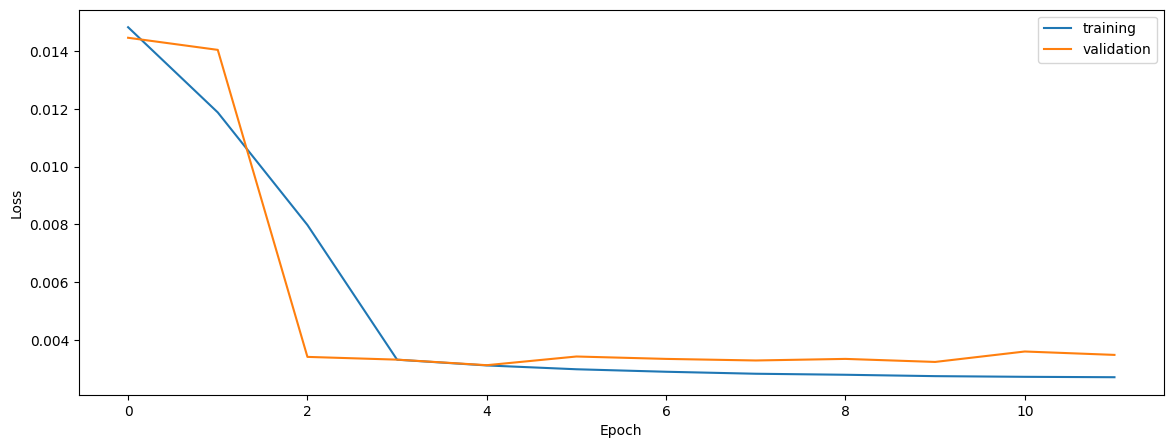

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8654954126741959
0.8938891090064606
0.9015432598148276


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8654954126741959
0.8938891090064606
0.9015432598148276


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8696088266164206
0.8963775056904408
0.9068370878224299


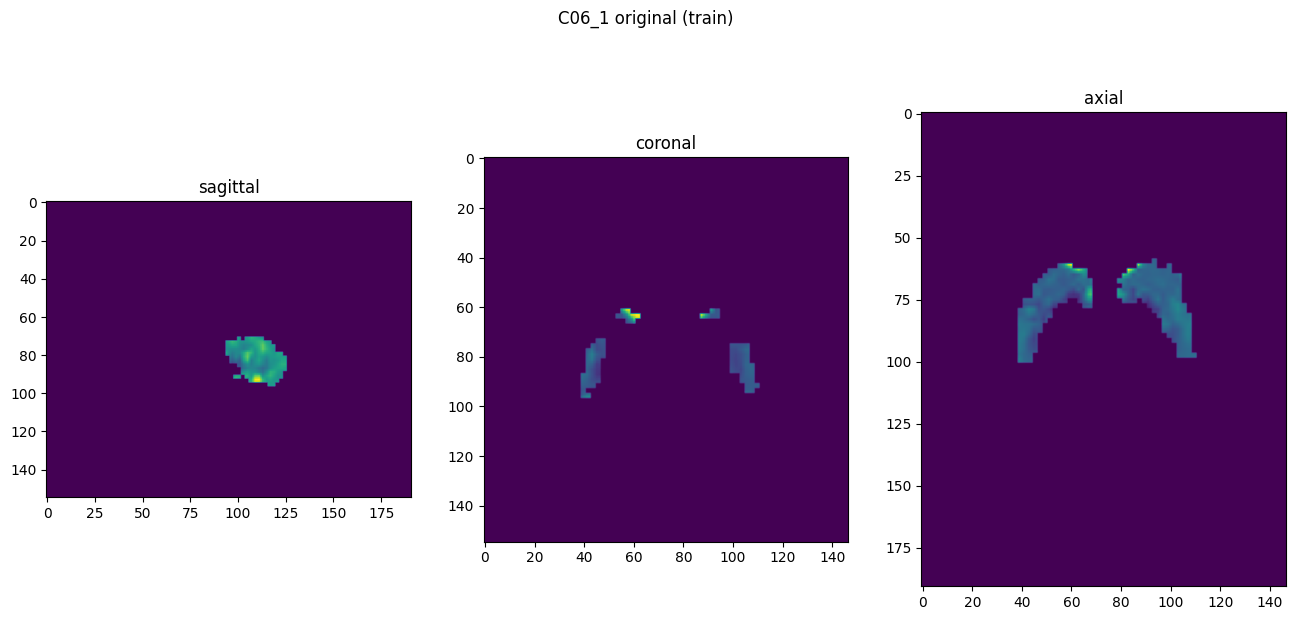

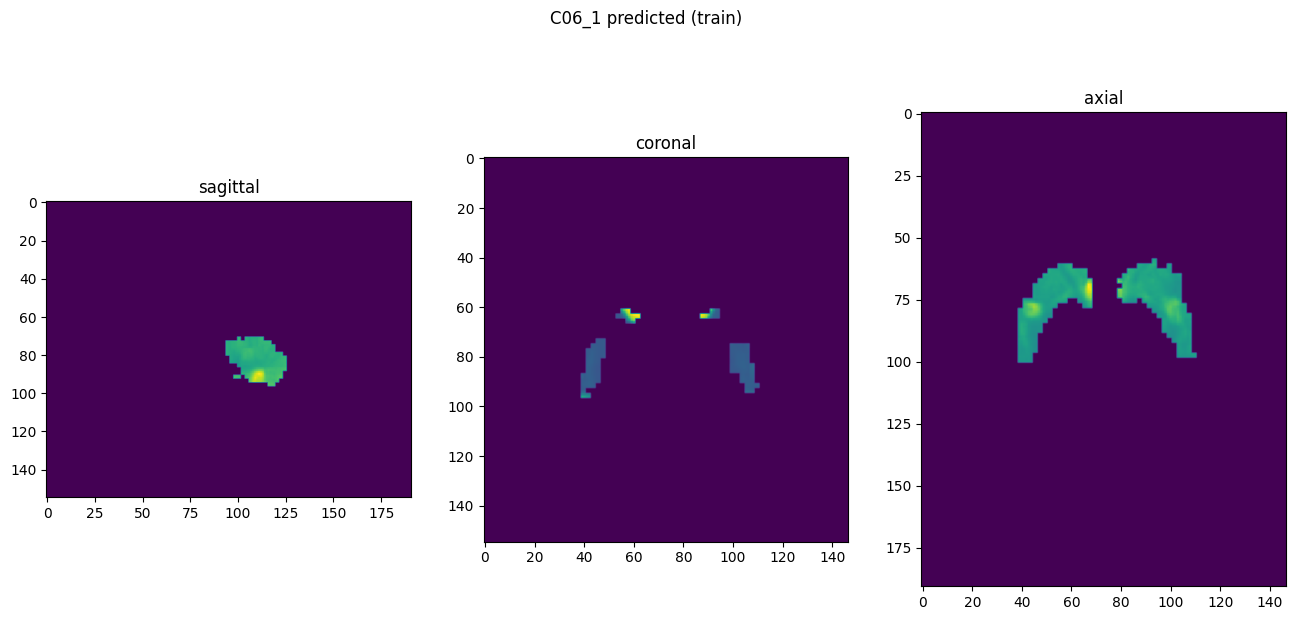

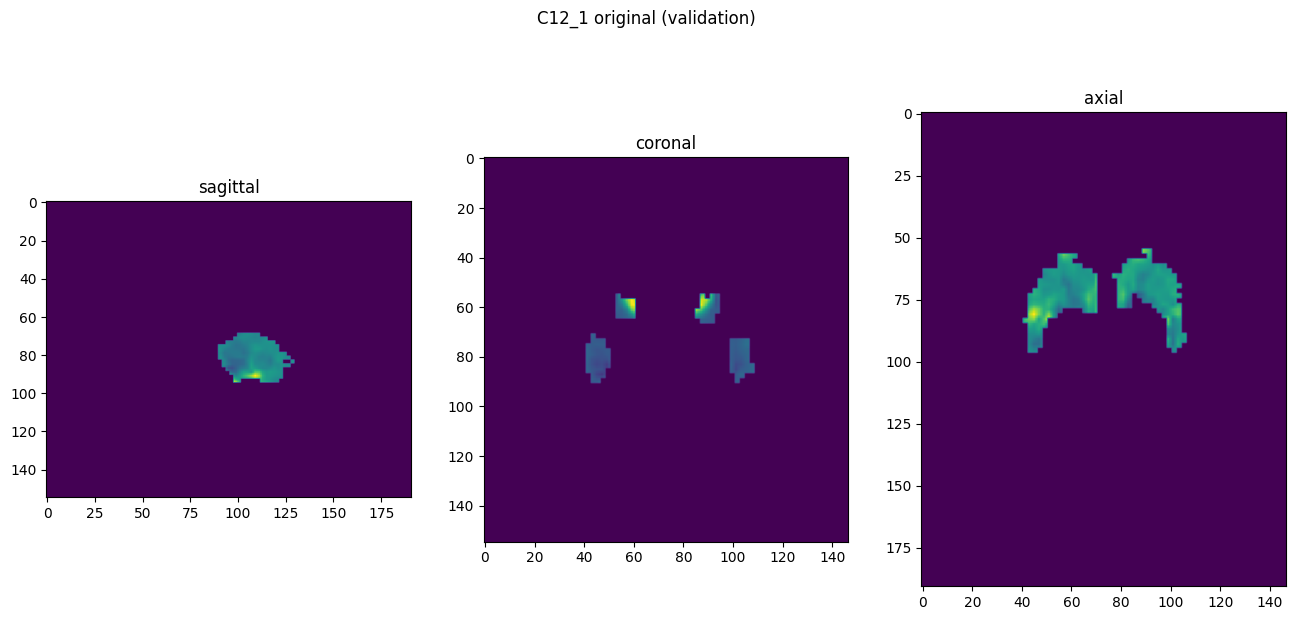

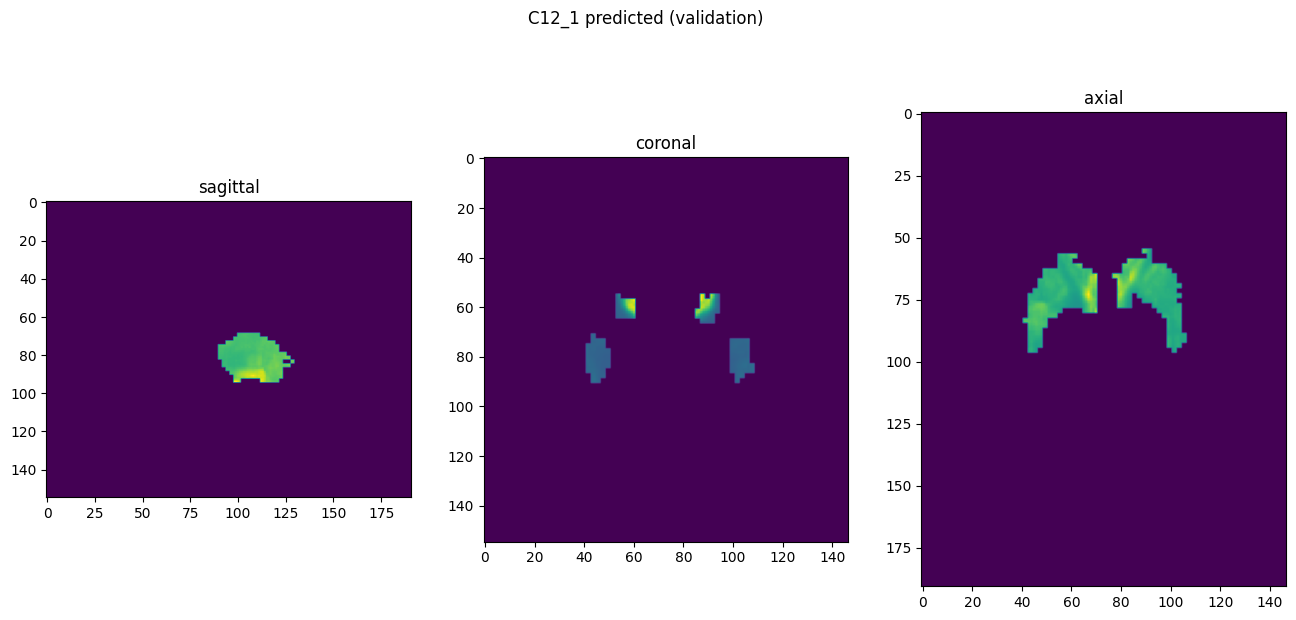

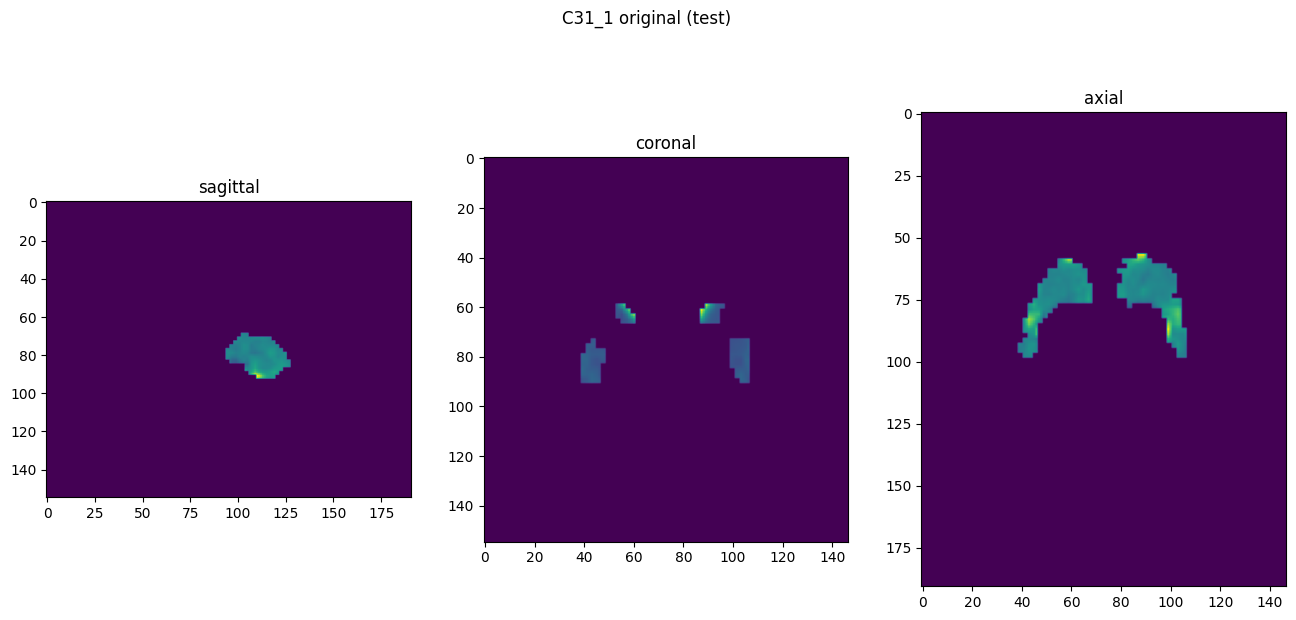

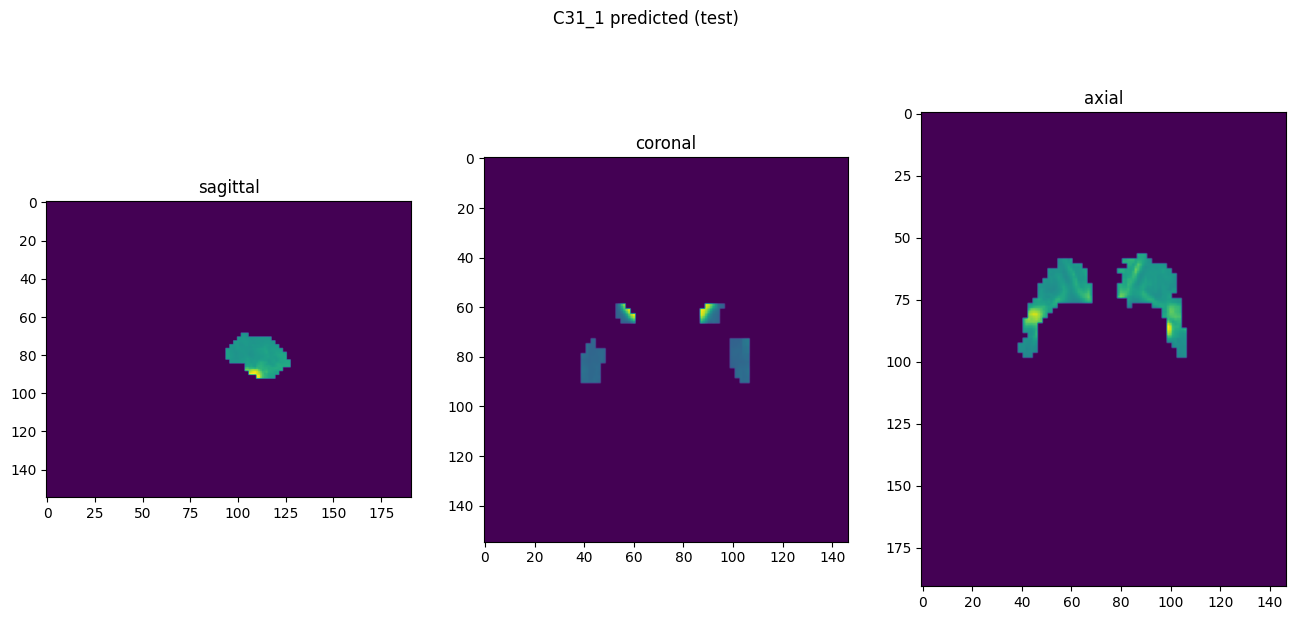

In [10]:
showResults(model, gen, threshold=None, background=False)